# Introduction

This project was created during the course of the "Attacks Against Machine Learning Models" lecture at Saarland University. The goal of this project is to attack a target model and find out, whether certain images where used as training data. This constitutes a Privacy Attack called Membership Inference.

In [22]:
import pickle
import torch

DATA_PATH = 'pickle/cifar10/resnet34/shadow.p'

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

with open(DATA_PATH, "rb") as f:
    dataset = pickle.load(f)

print(f"Shadow dataset contains {len(dataset)} images")

Using device mps
Shadow dataset contains 30000 images


In [94]:
import torchvision.models as models

model_str = "resnet34"
task_dataset = "cifar10"

MODEL_PATH = f'models/{model_str}_{task_dataset}.pth'

target_model = models.resnet34(num_classes=10).to(device)
# Change num_classes to 200 when you use the Tiny ImageNet dataset

state_dict = torch.load(MODEL_PATH, map_location=device)
target_model.load_state_dict(state_dict['net'])
# Test accuracy
ACC = state_dict['acc']
# Training epoch (start from 0)
EPOCH = state_dict['epoch']

print(f"Target model {model_str} on {task_dataset} was trained for {epoch + 1} epochs with final accuracy of {acc:.2f}%")

Target model resnet34 on cifar10 was trained for 200 epochs with final accuracy of 68.49%


# Methodology

As we want to replicate the target model with our own model (therefore called shadow model), we train it in a similar way to the target model. Fortunately, we have access to the number of epochs the training model was trained, so we have two possibilities moving forward:

1. We can use the number of epochs obtained to train our shadow model for the same amount
2. We can train our shadow model until it converges

We will do both in the following and compare the attack performance on `eval.p`.

First, we will need to split our shadow dataset, to obtain a portion of the data that will not be used for training. This test data contains only non-members of the shadow model and will later be used for training the attack model.

For the first approach, we just need the train-test-split because we know the number of epochs.

For the second approach, we add an additional validation-split to determine when the training converges on the validation data.

## 1. Fixed number of epochs

In [48]:
import random

shuffled_data = random.sample(dataset, len(dataset))
split = int(0.7 * len(shuffled_data))
train_dataset = shuffled_data[:split]
test_dataset = shuffled_data[split:]

print(f"Created train-test-split with training containing {len(train_dataset)} samples and test containing {len(test_dataset)}")

Created train-test-split with training containing 21000 samples and test containing 9000


## Data Inspection

Before going to the training, let's analyse the data a bit. Especially important is the distribution of the classes.

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.DataFrame(train_dataset, columns=["image", "label"])
train_df.head()

,image,label
0,"[[[tensor(0.9294), tensor(0.9216), tensor(0.91...",0
1,"[[[tensor(0.8863), tensor(0.8706), tensor(0.87...",8
2,"[[[tensor(1.), tensor(1.), tensor(1.), tensor(...",8
3,"[[[tensor(0.9804), tensor(0.9647), tensor(0.96...",8
4,"[[[tensor(0.5137), tensor(0.4706), tensor(0.52...",7


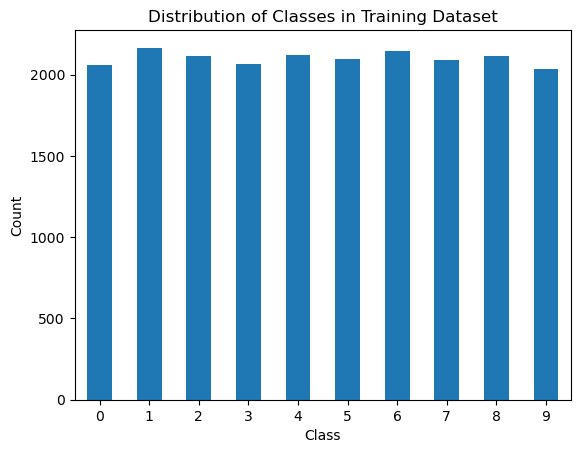

In [84]:
train_df["label"].value_counts().loc[range(10)].plot(kind='bar')
plt.title("Distribution of Classes in Training Dataset")
plt.xticks(rotation=0)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

We can see that the distribution across the classes is pretty even, so we continue with the training of the shadow model.

In [85]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [125]:
model = models.resnet34(num_classes=10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [110]:
def train_epoch():
    running_loss = 0.
    last_loss = 0.

    for batch_idx, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if batch_idx % 50 == 49:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch [{}/{}] loss: {}'.format(batch_idx + 1, len(train_dataloader) + 1, last_loss))
            running_loss = 0.
    return last_loss

In [131]:
def get_acc(model, dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    correct = 0
    
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).float().sum()
    model.train()
    return 100 * correct/len(dataset)

In [126]:
print("Starting training")
for epoch in range(EPOCH + 1):
    train_loss = train_epoch()
    print(f"=> epoch {epoch}, training loss: {train_loss}, training accuracy: {get_acc(model, train_dataset):.2f}")

Starting training
  batch [50/330] loss: 0.1068658356666565
  batch [100/330] loss: 0.08759368586540223
  batch [150/330] loss: 0.08197230792045593
  batch [200/330] loss: 0.07861152398586273
  batch [250/330] loss: 0.07530254852771759
  batch [300/330] loss: 0.07363667953014373
=> epoch 0, training loss: 0.07363667953014373, training accuracy: 48.11428451538086
  batch [50/330] loss: 0.06933662116527557
  batch [100/330] loss: 0.06879744338989258
  batch [150/330] loss: 0.06835883331298828
  batch [200/330] loss: 0.06506826114654542
  batch [250/330] loss: 0.0622162309885025
  batch [300/330] loss: 0.06394648241996766
=> epoch 1, training loss: 0.06394648241996766, training accuracy: 49.652381896972656
  batch [50/330] loss: 0.05879727125167847
  batch [100/330] loss: 0.06049016612768173
  batch [150/330] loss: 0.056367367327213286
  batch [200/330] loss: 0.05578539550304413
  batch [250/330] loss: 0.05530743956565857
  batch [300/330] loss: 0.05693060773611069
=> epoch 2, training lo

In [127]:
torch.save(model.state_dict(), "model_resnet_cifar10_200")

For the sake of comparability, let's examine the accuracy that target and shadow model obtain on a test dataset:

In [132]:
print(f"Target model accuracy after {EPOCH + 1} epoch: {get_acc(target_model, test_dataset):.2f} %")
print(f"Shadow model accuracy after {EPOCH + 1} epoch: {get_acc(model, test_dataset):.2f} %")

Target model accuracy after 200 epoch: 67.57 %
Shadow model accuracy after 200 epoch: 69.69 %


As we can see, the model performance is very similar, making our trained model a good proxy for the attack.